# 🧪 SEMMA
Sample → Explore → Modify → Model → Assess.



Assignment done by :- **Dev Mulchandani**

In [1]:
#@title Upload and (optionally) sample the data
from google.colab import files
import pandas as pd, io
up = files.upload()
assert up, 'No file uploaded.'
fname = list(up.keys())[0]
print('Using file:', fname)
if fname.lower().endswith('.csv'):
    df = pd.read_csv(io.BytesIO(up[fname]))
else:
    df = pd.read_excel(io.BytesIO(up[fname]))
print('Full shape:', df.shape)
try:
    frac = float(input('Enter sample fraction (e.g., 0.5 for 50%, 1 for all): ') or 1)
except Exception:
    frac = 1
df = df.sample(frac=frac, random_state=42)
print('Sampled shape:', df.shape)

Saving train.csv to train.csv
Using file: train.csv
Full shape: (1460, 81)
Enter sample fraction (e.g., 0.5 for 50%, 1 for all): 1
Sampled shape: (1460, 81)


## Explore

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
892,893,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal,154500
1105,1106,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,325000
413,414,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,115000
522,523,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,Normal,159000
1036,1037,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,315500



Dtypes:
 Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

Missing values per column:
 Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460.0,NaN,NaN,NaN,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,NaN,NaN,NaN,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201.0,NaN,NaN,NaN,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,NaN,NaN,NaN,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1460.0,NaN,NaN,NaN,6.321918,2.703626,1.0,5.0,6.0,8.0,12.0
YrSold,1460.0,NaN,NaN,NaN,2007.815753,1.328095,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1460,9,WD,1267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1460,6,Normal,1198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


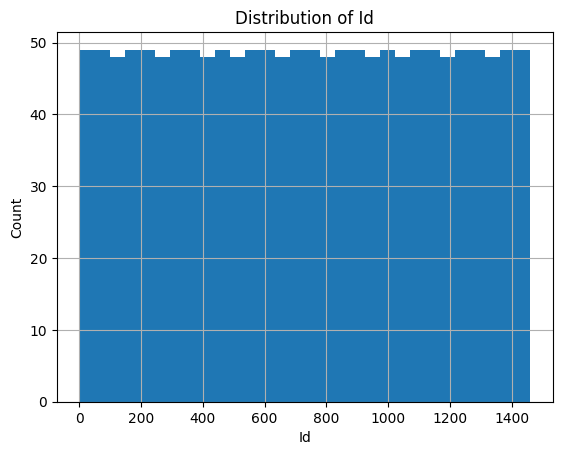

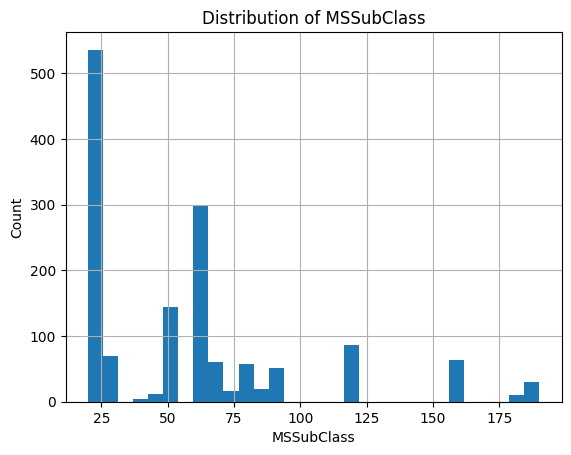

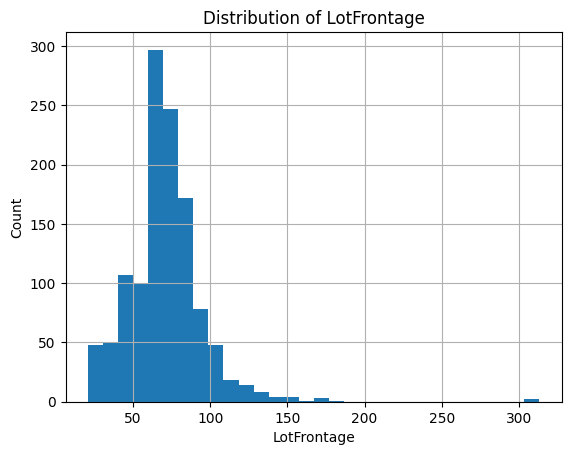

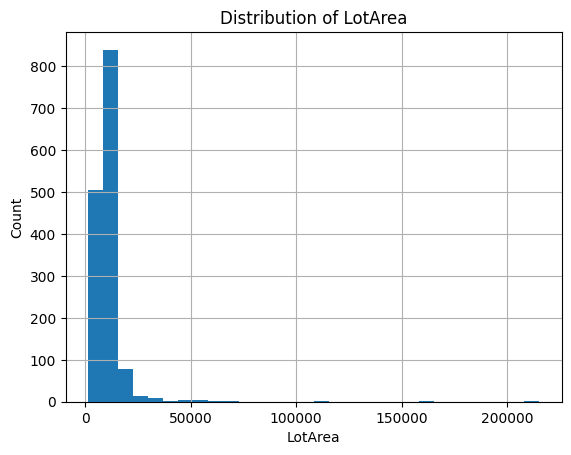

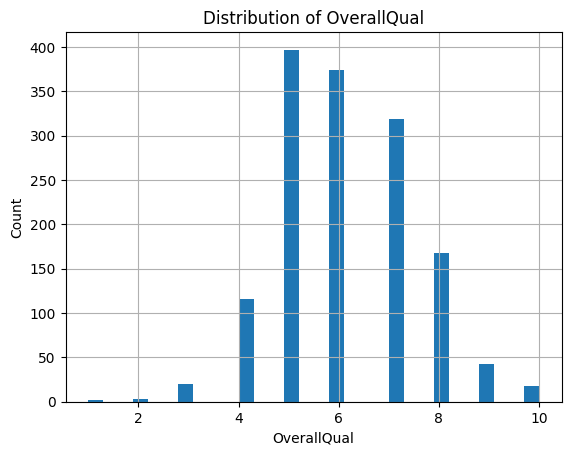

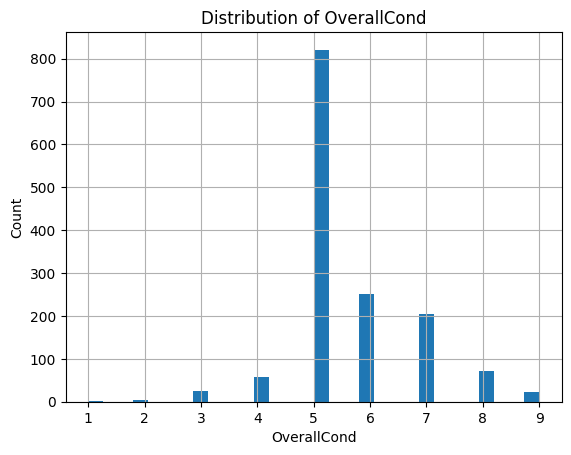

In [2]:
#@title Quick EDA
display(df.head())
print('\nDtypes:\n', df.dtypes)
print('\nMissing values per column:\n', df.isna().sum())
display(df.describe(include='all').transpose())
import matplotlib.pyplot as plt
for col in df.select_dtypes(include=['number']).columns[:6]:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

## Modify

In [7]:
# MODIFY (robust): set target & build preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


# Target for House Prices
target = "SalePrice"   # <- keep this
task = "r"             # regression

assert target in df.columns, f"{target} not found in df.columns"

# Split features/target; keep all rows (we'll impute missing values)
y = df[target]
X = df.drop(columns=[target])

# Preprocessing:
# - numeric: median impute
# - categorical: most frequent impute + one-hot (ignore unseen levels)
numeric_proc = SimpleImputer(strategy="median")
categorical_proc = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_proc, selector(dtype_include=["int64", "float64"])),
        ("cat", categorical_proc, selector(dtype_include=["object"]))
    ]
)

print("Shapes – X:", X.shape, " y:", y.shape)
print("Numeric cols:", len(selector(dtype_include=["int64","float64"])(X)),
      "Categorical cols:", len(selector(dtype_include=["object"])(X)))


Shapes – X: (1460, 80)  y: (1460,)
Numeric cols: 37 Categorical cols: 43


## Model

In [9]:
# MODEL (robust): preprocessing + model in one pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Choose a baseline regressor (you can swap for RandomForestRegressor if you like)
regressor = LinearRegression()

pipe = Pipeline(steps=[
    ("preprocess", preprocess),   # uses your ColumnTransformer from previous cell
    ("model", regressor)
])

# Split BEFORE fitting; the pipeline prevents data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
pipe.fit(X_train, y_train)

# Predictions and evaluation
pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)  # compute RMSE manually
r2 = r2_score(y_test, pred)

print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:,.3f}")


MAE:  16,457.40
RMSE: 24,254.52
R²:   0.890


## Assess

In [11]:
# 🧪 ASSESS — Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict using the trained pipeline
pred = pipe.predict(X_test)

# Compute evaluation metrics for regression
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

print("🔍 Evaluation Results:")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:,.3f}")

# Optional: show comparison of actual vs predicted
comparison = (
    np.round(
        np.column_stack((y_test.values[:10], pred[:10])),
        2
    )
)
print("\nSample Predictions (Actual vs Predicted):")
print("Actual | Predicted")
print(comparison)


🔍 Evaluation Results:
MAE:  16,457.40
RMSE: 24,254.52
R²:   0.890

Sample Predictions (Actual vs Predicted):
Actual | Predicted
[[120000.   115363.17]
 [100000.   100453.61]
 [274900.   341823.05]
 [179665.   217818.96]
 [320000.   273456.4 ]
 [209500.   228878.69]
 [130000.   133593.81]
 [143000.   161287.75]
 [180000.   168571.41]
 [157000.   186771.78]]


### Notes
- **Sample**: Subset if large
- **Explore**: Understand structure & missingness
- **Modify**: Clean + one-hot encode
- **Model**: Simple baseline
- **Assess**: Report and interpret metrics